In [115]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
def load_unit_data(unit):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)

def load_all_data():
    units = range(0, 20)
    df_all = pd.DataFrame()
    for idx, unit in enumerate(units):
        file_name = "../data/processed/train/unit{}_rms_more_features.csv".format("000{}".format(unit) if unit < 10 else "00{}".format(unit))
        file_df = pd.read_csv(file_name, index_col=0)
        file_df['timestamp'] = pd.to_datetime(file_df['timestamp'])
        df_all = df_all.append(file_df)
    return df_all
    

prepare feature: time remaining until failure

In [54]:
for unit in range(0, 20):
    df_unit = load_unit_data(unit)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    dt_max = df_unit['timestamp'].max()
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    time_diffs, warnings_til_now, errors_til_now = [], [], []
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    for idx, row in df_unit.iterrows():
        # time diff in days until failure
        time_diff = dt_max - row['timestamp']
        time_diffs.append(divmod(time_diff.total_seconds(), 60)[0] / (60 * 24))
        
        # num of accumulated warnings/errors before current observation
        df_before = df_alarm[(df_alarm['timestamp'] < row['timestamp'])]
        accum_warnings = len(df_before[df_before['warning'] == 'warning'].index)
        accum_errors = len(df_before[df_before['warning'] == 'error'].index)
        warnings_til_now.append(accum_warnings)
        errors_til_now.append(accum_errors)

    df_unit['hours_to_failure'] = time_diffs
    df_unit['accumulated_warnings'] = warnings_til_now
    df_unit['accumulated_errors'] = errors_til_now
    df_unit.to_csv("../data/processed/train/unit{}_rms_more_features.csv".format(unit_name))
print("Done")

Done


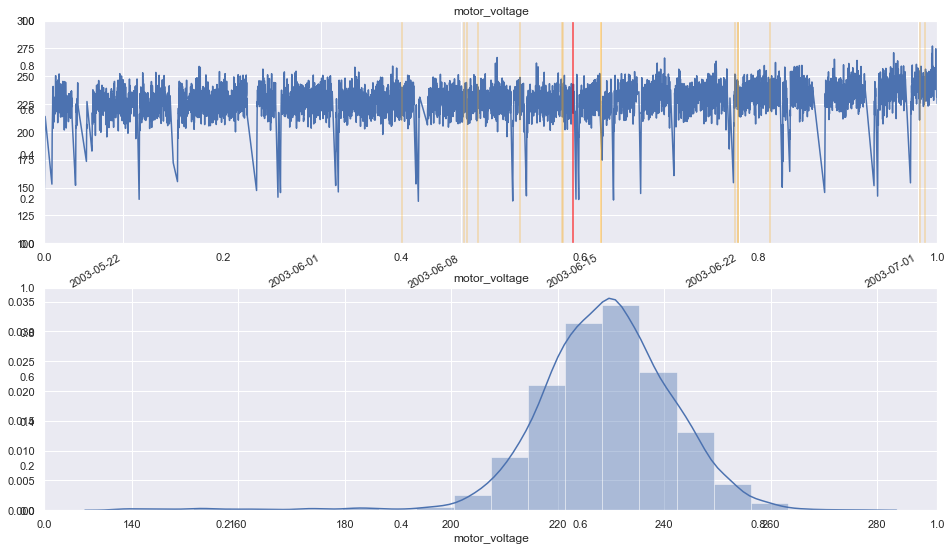

In [42]:
def plot_feature_in_df(unit, feature_name, ylim_low=-20, ylim_high=3000, bins=20):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    df_unit = pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)
    df_unit['timestamp'] = pd.to_datetime(df_unit['timestamp'])
    sns.set()
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(feature_name)
    df_unit.set_index('timestamp', inplace=True)
    if ylim_low is None and ylim_high is None:
        df_unit[feature_name].plot(label=feature_name)
    else:
        df_unit[feature_name].plot(ylim=(ylim_low, ylim_high), label=feature_name)
        
    # plot warnings and errors
    df_alarm = pd.read_csv("../data/raw/train/unit{}_alarms.csv".format(unit_name), header=None, names=['timestamp', 'warning'])
    df_alarm['timestamp'] = pd.to_datetime(df_alarm['timestamp'])
    df_alarm.set_index('timestamp', inplace=True)
    warning_x = df_alarm[df_alarm['warning'] == 'warning'].index.values
    error_x = df_alarm[df_alarm['warning'] == 'error'].index.values
    for warning in warning_x:
        plt.axvline(x=warning, color='orange', alpha=0.3, label='warning')
    for error in error_x:
        plt.axvline(x=error, color='red', alpha=0.7, label='error')
    #plt.legend()
    ax2 = fig.add_subplot(212)
    sns.distplot(df_unit[feature_name], bins=bins)
    ax2.title.set_text(feature_name)
    plt.show()
plot_feature_in_df(15, 'motor_voltage', ylim_low=100, ylim_high=300)

In [4]:
df_all = load_all_data()
df_all

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,hours_to_failure,accumulated_warnings,accumulated_errors
50,2003-12-14 04:15:20.899117138,1063.729373,165.879228,19.281104,35.767971,26.387341,636.556250,0,0
53,2003-12-14 04:45:12.721247385,956.579922,217.484012,25.042943,63.002208,34.350839,636.535417,0,0
54,2003-12-14 04:55:40.840586778,1063.856934,206.792646,28.782024,69.830473,28.464714,636.528472,0,0
55,2003-12-14 05:05:37.291038943,1005.212018,219.900341,29.302032,68.019838,39.165607,636.521528,0,0
56,2003-12-14 05:17:06.465193131,1115.011284,220.373208,30.767473,79.283341,32.983723,636.513194,0,0
...,...,...,...,...,...,...,...,...,...
24341,2005-04-11 18:16:25.989419843,1042.179737,307.539123,47.975455,218.791347,100.807647,0.027778,53,1
24342,2005-04-11 18:26:55.689073846,1069.597134,297.454082,47.263750,218.882763,109.359761,0.020139,53,1
24343,2005-04-11 18:35:25.402556965,1116.392388,316.277175,50.395914,218.935540,102.472228,0.014583,53,1
24344,2005-04-11 18:45:44.900113142,1122.974015,320.776152,49.165122,225.527057,103.086940,0.006944,53,1


In [120]:
df_all_features = df_all[df_all.columns[1:]]
df_all
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

Y_LABEL = 'hours_to_failure'
train_set, test_set = train_test_split(df_all_features, test_size=0.2, random_state=42)
x_train = num_pipeline.fit_transform(train_set.drop(columns=[Y_LABEL], axis=1))
x_test = num_pipeline.fit_transform(test_set.drop(columns=[Y_LABEL], axis=1))
y_train, y_test = num_pipeline.fit_transform(train_set[[Y_LABEL]]), num_pipeline.fit_transform(test_set[[Y_LABEL]])

In [82]:
aa = pd.DataFrame(x_train)
aa[0].min()

-3.6092170467109317

Epoch 1/500
669744/669744 [==============================] - 80s 120us/step - loss: 0.3399 - coeff_determination: 0.6375
Epoch 2/500
669744/669744 [==============================] - 76s 113us/step - loss: 0.3374 - coeff_determination: 0.6406
Epoch 3/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3351 - coeff_determination: 0.6433
Epoch 4/500
669744/669744 [==============================] - 76s 113us/step - loss: 0.3330 - coeff_determination: 0.6451
Epoch 5/500
669744/669744 [==============================] - 76s 114us/step - loss: 0.3310 - coeff_determination: 0.6482
Epoch 6/500
669744/669744 [==============================] - 76s 114us/step - loss: 0.3292 - coeff_determination: 0.6502
Epoch 7/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3275 - coeff_determination: 0.6524
Epoch 8/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3260 - coeff_determination: 0.6535
Epoch 9/500
669744/669744 [=====

669744/669744 [==============================] - 76s 114us/step - loss: 0.3048 - coeff_determination: 0.6791
Epoch 69/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3047 - coeff_determination: 0.6786
Epoch 70/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3047 - coeff_determination: 0.6798
Epoch 71/500
669744/669744 [==============================] - 77s 116us/step - loss: 0.3046 - coeff_determination: 0.6798
Epoch 72/500
669744/669744 [==============================] - 77s 115us/step - loss: 0.3045 - coeff_determination: 0.6804
Epoch 73/500
669744/669744 [==============================] - 77s 116us/step - loss: 0.3045 - coeff_determination: 0.6797
Epoch 74/500
669744/669744 [==============================] - 78s 116us/step - loss: 0.3044 - coeff_determination: 0.6794
Epoch 75/500
669744/669744 [==============================] - 78s 116us/step - loss: 0.3043 - coeff_determination: 0.6797
Epoch 76/500
669744/669744 [=========

669744/669744 [==============================] - 72s 108us/step - loss: 0.3013 - coeff_determination: 0.6831
Epoch 135/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.3013 - coeff_determination: 0.6825
Epoch 136/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.3013 - coeff_determination: 0.6827
Epoch 137/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.3012 - coeff_determination: 0.6832
Epoch 138/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.3012 - coeff_determination: 0.6833
Epoch 139/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.3012 - coeff_determination: 0.6831
Epoch 140/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.3011 - coeff_determination: 0.6827
Epoch 141/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.3011 - coeff_determination: 0.6828
Epoch 142/500
669744/669744 [=

669744/669744 [==============================] - 72s 108us/step - loss: 0.2996 - coeff_determination: 0.6848
Epoch 201/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2995 - coeff_determination: 0.6843
Epoch 202/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2995 - coeff_determination: 0.6850
Epoch 203/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2995 - coeff_determination: 0.6849
Epoch 204/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2995 - coeff_determination: 0.6853
Epoch 205/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2995 - coeff_determination: 0.6844
Epoch 206/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2994 - coeff_determination: 0.68570s - loss: 0.2995 - coeff_determination: 0.6
Epoch 207/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2994 - coeff_determin

669744/669744 [==============================] - 72s 108us/step - loss: 0.2985 - coeff_determination: 0.6860
Epoch 267/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2985 - coeff_determination: 0.6860
Epoch 268/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2984 - coeff_determination: 0.6859
Epoch 269/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2984 - coeff_determination: 0.6861
Epoch 270/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2984 - coeff_determination: 0.6851
Epoch 271/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2984 - coeff_determination: 0.6850
Epoch 272/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2984 - coeff_determination: 0.6859
Epoch 273/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2984 - coeff_determination: 0.6861
Epoch 274/500
669744/669744 [=

669744/669744 [==============================] - 73s 108us/step - loss: 0.2977 - coeff_determination: 0.6862
Epoch 333/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2977 - coeff_determination: 0.6866
Epoch 334/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2977 - coeff_determination: 0.6864
Epoch 335/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2977 - coeff_determination: 0.6864
Epoch 336/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2977 - coeff_determination: 0.6861
Epoch 337/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2976 - coeff_determination: 0.6865
Epoch 338/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2976 - coeff_determination: 0.6860
Epoch 339/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2976 - coeff_determination: 0.6868
Epoch 340/500
669744/669744 [=

669744/669744 [==============================] - 73s 108us/step - loss: 0.2971 - coeff_determination: 0.6869
Epoch 399/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2971 - coeff_determination: 0.6873
Epoch 400/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2971 - coeff_determination: 0.6872
Epoch 401/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2971 - coeff_determination: 0.6871
Epoch 402/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2971 - coeff_determination: 0.6870
Epoch 403/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2971 - coeff_determination: 0.6868
Epoch 404/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2971 - coeff_determination: 0.6860
Epoch 405/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2971 - coeff_determination: 0.6874
Epoch 406/500
669744/669744 [=

669744/669744 [==============================] - 73s 108us/step - loss: 0.2967 - coeff_determination: 0.6875
Epoch 465/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2966 - coeff_determination: 0.6869
Epoch 466/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2966 - coeff_determination: 0.6879
Epoch 467/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2966 - coeff_determination: 0.6875
Epoch 468/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2966 - coeff_determination: 0.6875
Epoch 469/500
669744/669744 [==============================] - 73s 108us/step - loss: 0.2966 - coeff_determination: 0.6875
Epoch 470/500
669744/669744 [==============================] - 72s 108us/step - loss: 0.2966 - coeff_determination: 0.6871
Epoch 471/500
669744/669744 [==============================] - 73s 109us/step - loss: 0.2966 - coeff_determination: 0.6873
Epoch 472/500
669744/669744 [=

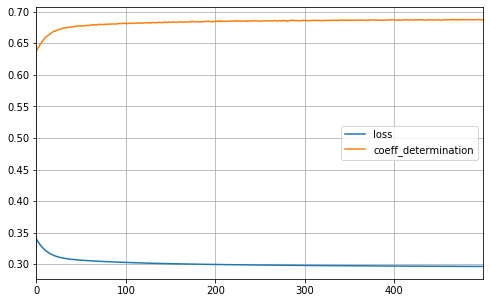

In [124]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_keras_model(activation='selu', optimizer='adam', neuron=50, init='lecun_normal'):
#     model_sequences = [
#         keras.layers.Dense(units=neuron, activation=activation, kernel_initializer=init, input_shape=x_train.shape[1:]),      
#     ]
    
#     for i in range(7):
#         model_sequences.append(keras.layers.Dense(units=neuron / (i+1), activation=activation, kernel_initializer=init, input_shape=x_train.shape[1:]))
#     model_sequences.append(keras.layers.BatchNormalization())
#     model_sequences.append(Dense(units=1, activation=activation, name='score_output'))
#     #model_sequences.append(keras.layers.Activation(activation))

#     nn_model = keras.models.Sequential(model_sequences)
    
    input_layer = Input(shape=x_train.shape[1:])
    layer = Dense(units=neuron,  kernel_initializer=init, input_shape=x_train.shape[1:])(input_layer)
    
    for i in range(5):
        layer = Dense(units=neuron, activation=activation, kernel_initializer=init)(layer)

    score_output = Dense(units=1, activation=activation, name='score_output')(layer)
    nn_model = Model(inputs=input_layer, outputs=[score_output])
    
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
    return nn_model

activation = LeakyReLU(alpha=0.3)
#nn_model = create_keras_model(activation=activation, optimizer='Adadelta', neuron=100, init='lecun_uniform')
#print("Keras model constructed")
# history = nn_model.fit(x_train, y_train, epochs=1000, verbose=1)
# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# #plt.gca().set_ylim(0, 1)
# plt.show()

with open('../models/failure_predicting/sequential_1k_epoch.json') as f:
    nn_model = model_from_json(f.read())
optimizer = tensorflow.keras.optimizers.Adadelta(lr=1e-5)
nn_model.load_weights('../models/failure_predicting/sequential_1k_epoch.h5')
nn_model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
history = nn_model.fit(x_train, y_train, epochs=500, verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [130]:
def save_keras_model(model, history, file_name):
    model_json = model.to_json()
    with open("../models/failure_predicting/{}.json".format(file_name), 'w') as json_file:
        json_file.write(model_json)
    model.save_weights("../models/failure_predicting/{}.h5".format(file_name))
    with open('../models/failure_predicting/{}.history'.format(file_name), 'wb') as file_history:
        pickle.dump(history.history, file_history)
    print("model saved")
save_keras_model(nn_model, history, "sequential_15k_epoch")

model saved


In [ ]:
nn_model = 